In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import pandas as pd

# Regridding

Regridding is the process of converting gridded data from one resolution to another. In the example here, we'll convert a flux dataset from its native resolution to the resolution of NAME model output that we store for the European domain.

This example uses the [xesmf](https://xesmf.readthedocs.io/en/latest/) package (Zhuang et al., 2023), which works well with [xarray](https://docs.xarray.dev/en/stable/index.html) datasets.

The example that we'll use here is a radon flux dataset (Karstens et al., 2015). This file is well formatted, with well definied coordinates. Not all files will be so well 

In [3]:
# Rn files from https://doi.pangaea.de/10.1594/PANGAEA.854715
with xr.open_dataset("~/Downloads/rn_project/InGOS_Radon_fluxmap_v2.0_noah_2006-2012.nc") as f:
    ds_flux_rn = f.load()

In [12]:
# Let's look at the contents
ds_flux_rn

<xarray.Dataset>
Dimensions:  (lon: 504, lat: 504, time: 84)
Coordinates:
  * lon      (lon) float32 -11.96 -11.88 -11.79 -11.71 ... 29.79 29.88 29.96
  * lat      (lat) float32 30.04 30.12 30.21 30.29 ... 71.71 71.79 71.88 71.96
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2012-12-01
Data variables:
    rn_flux  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.4
    title:        InGOS Radon flux map v2.0 (using GLDAS/Noah soil moisture)
    institution:  MPI Biogeochemistry Jena Germany & Institut fuer Umweltphys...
    contact:      Ute Karstens ute.karstens@nateko.lu.se

In [4]:
# For this dataset, time is currently stored as a float with the format YYYYMMDD. Convert to datetime
dates = [str(int(date)) for date in ds_flux_rn.time.values]
ds_flux_rn['time'] = [pd.to_datetime(date) for date in dates]

Now that we've read in and formatted our input dataset, we can read in the grid that we want to regrid our dataset onto:

In [5]:
# Import an example of NAME grid from footprint file
with xr.open_dataset("../data/fp_RGL-90magl_UKV_EUROPE_part.nc") as f:
    ds_fp_rn = f.load()

We want to convert from the grid defined by the lon and lat coordinates in ```ds_flux_rn``` to that in ```ds_fp_rn```. Here, we will use the "conservative" regridder, as we want to make sure the flux isn't changed in the regridding process. For other regridding routines, something simpler like a "bilinear" method may be more efficient:

In [10]:
# Use xesmf to regrid the radon flux to the NAME grid
regridder = xe.Regridder(ds_flux_rn, ds_fp_rn, 'conservative')
ds_flux_rn_regrid = regridder(ds_flux_rn)

# replace Nans with zeros (Nans were used to indicate zero flux in this dataset)
ds_flux_rn_regrid = ds_flux_rn_regrid.fillna(0)

In [11]:
ds_flux_rn_regrid

<xarray.Dataset>
Dimensions:  (time: 84, lat: 293, lon: 391)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2012-12-01
  * lon      (lon) float32 -97.9 -97.55 -97.2 -96.84 ... 38.32 38.68 39.03 39.38
  * lat      (lat) float32 10.73 10.96 11.2 11.43 ... 78.36 78.59 78.82 79.06
Data variables:
    rn_flux  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  conservative

Let's plot the output to make sure it looks sensible. Note that the regridder has done two things in this case: it's changed the resolution, but it's also expanded the domain substantially. We've filled the extended domain with zeros here.

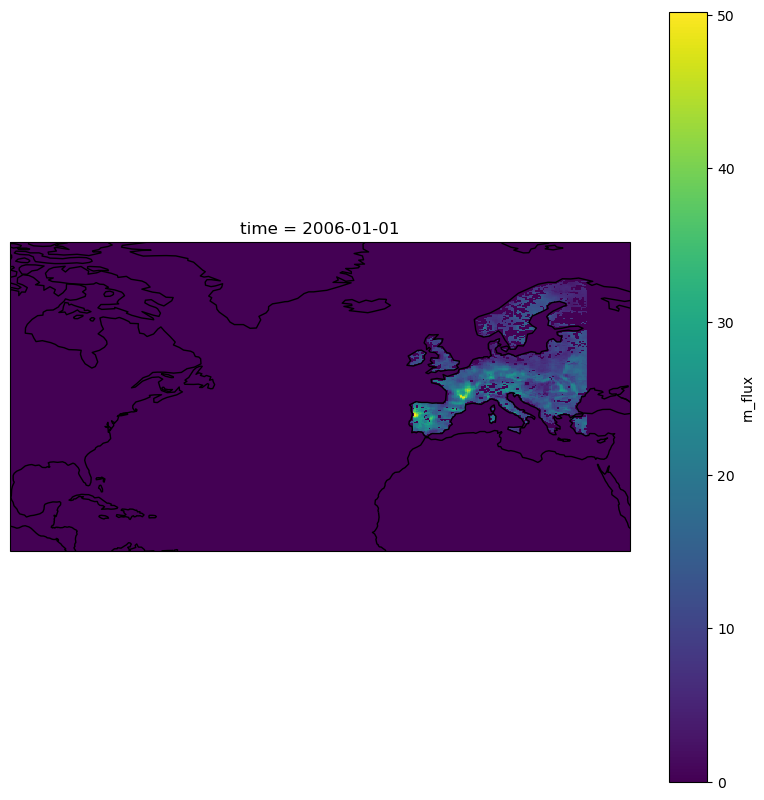

In [13]:
# Plot the regridded radon flux
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ds_flux_rn_regrid['rn_flux'].sel({"time": "2006-01-01"}).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
plt.show()


In [14]:
ds_flux_rn_regrid

<xarray.Dataset>
Dimensions:  (time: 84, lat: 293, lon: 391)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2012-12-01
  * lon      (lon) float32 -97.9 -97.55 -97.2 -96.84 ... 38.32 38.68 39.03 39.38
  * lat      (lat) float32 10.73 10.96 11.2 11.43 ... 78.36 78.59 78.82 79.06
Data variables:
    rn_flux  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  conservative

## Next steps

It's practice to check that the total flux hasn't changed in this process. To do this, because the flux above is definied per unit area, you'll need to account for the area of each grid cell in the input and the output grid. So you'll want to make sure that $\sum{_i}f_iA_i$ is conserved, where $f$ is the flux, $A$ is the area of each grid cell and $i$ is a grid cell. The sum is over the original domain (although in this case, since the extended domain is full of zeros, we could compare the sum over the new domain).

## References

Karstens, U., Schwingshackl, C., Schmithüsen, D., and Levin, I.: A process-based 222-radon flux map for Europe and its comparison to long-term observations, Atmospheric Chemistry and Physics, 15, 12845–12865, https://doi.org/10.5194/acp-15-12845-2015, 2015.

Jiawei Zhuang, raphael dussin, David Huard, Pascal Bourgault, Anderson Banihirwe, Stephane Raynaud, Brewster Malevich, Martin Schupfner, Filipe, Sam Levang, Charles Gauthier, André Jüling, Mattia Almansi, RichardScottOZ, RondeauG, Stephan Rasp, Trevor James Smith, Jemma Stachelek, Matthew Plough, … Xianxiang Li. (2023). pangeo-data/xESMF: v0.8.2 (v0.8.2). Zenodo. https://doi.org/10.5281/zenodo.8356796